# Latent representation analysis
In this notebook we analyse and compare the latent representations produced by the Wav2Vec2 feature extractor and the brain feature extractor

## Preperation

### Imports

In [1]:
from src.args.base_args import B2TDatasetArgsModel
from src.datasets.brain2text_w_phonemes import Brain2TextWPhonemesDataset
from src.analysis.latent_analysis_util import generate_speech_multiple, generate_audio_representations, generate_brain_representations
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from src.args.yaml_config import YamlConfig
from src.analysis.latent_analysis_util import per_seq_avg_of_dimreduced_repr
from src.analysis.latent_analysis_util import flatten_square_matrix_rm_diag
from scipy.spatial.distance import cdist
from typing import NamedTuple
from math import sqrt

yaml_config = YamlConfig().config

/hpi/fs00/home/tobias.fiedler/miniconda3/envs/b2t/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_ds = Brain2TextWPhonemesDataset(B2TDatasetArgsModel(limit_samples=900), yaml_config, "test")
test_transcriptions = [test_ds[i].transcription for i in range(len(test_ds))]

### Generate speech for test transcriptions

### Extract test transcriptions

In [3]:
generate_speech_multiple(test_transcriptions)

880/880 audios generated (0 newly generated)



## Generate audio latent representations

In [4]:
audio_representations = generate_audio_representations(test_ds) 

Some weights of Wav2Vec2WithoutFeatExtrForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


880/880 audio representations generated 



## Generate brain latent representations

In [5]:
brain_representations = generate_brain_representations(test_ds)

/hpi/fs00/home/tobias.fiedler/miniconda3/envs/b2t/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449183005/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of Wav2Vec2WithoutFeatExtrForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/hpi/fs00/home/tobias.fiedler/brain2text/src/model/b2p2t_model.py:90: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be 

880/880 brain representations generated 



In [6]:
all_data = audio_representations.non_aggregated + brain_representations.non_aggregated

def scatter_a_vs_b_dimreduced_nonagg(dimreduced: np.ndarray, title: str=""):
    plt.scatter(dimreduced[:len(audio_representations.non_aggregated), 0], dimreduced[:len(audio_representations.non_aggregated), 1], c="red", label="Audio representations", alpha=0.02)
    plt.scatter(dimreduced[len(audio_representations.non_aggregated):, 0], dimreduced[len(audio_representations.non_aggregated):, 1], c="blue", label="Brain representations", alpha=0.02)
    plt.legend()
    plt.title(title)
    plt.show()

def scatter_a_vs_b_dimreduced_aggregated(dimreduced_agg: np.ndarray, title: str=""):
    assert len(dimreduced_agg) == len(test_ds) * 2, f"Expected {len(test_ds) * 2} sequences, got {len(dimreduced_agg)}"
    plt.scatter(dimreduced_agg[:len(test_ds), 0], dimreduced_agg[:len(test_ds), 1], c="red", label="Audio representations", alpha=0.4)
    plt.scatter(dimreduced_agg[len(test_ds):, 0], dimreduced_agg[len(test_ds):, 1], c="blue", label="Brain representations", alpha=0.4)
    plt.legend()
    plt.title(title)
    plt.show()

def scatter_transcription_idx_clusters(dimreduced: np.ndarray):
    plt.scatter(dimreduced[:len(audio_representations.non_aggregated), 0], dimreduced[:len(audio_representations.non_aggregated), 1], c=[rep.idx for rep in audio_representations.non_aggregated], cmap="tab20", label="Audio representations", alpha=0.8, s=1) # type: ignore
    plt.scatter(dimreduced[len(audio_representations.non_aggregated):, 0], dimreduced[len(audio_representations.non_aggregated):, 1], c=[rep.idx for rep in brain_representations.non_aggregated], cmap="tab20", label="Brain representations", alpha=0.8, marker='x', s=1) # type: ignore
    plt.legend()
    plt.title("Same color = same sample")
    plt.show()

def distmat_a_b_pairwise(dimreduced_agg: np.ndarray, title=""):
    dimreduced_distances = cdist(dimreduced_agg[:len(test_ds)], dimreduced_agg[len(test_ds):],'cosine')
    plt.imshow(dimreduced_distances)
    plt.title(title)
    plt.colorbar()

class DimreducedSeries(NamedTuple):
    dimreduced_agg: np.ndarray
    color: str
    label: str

## Pre W2V encoder
### Perform Dimensionality reduction

In [7]:
all_data_pre_w2venc_np = torch.stack([rep for _, rep,_ in all_data]).numpy()
pre_w2venc_dim_reducer = TSNE(n_components=2)
all_data_pre_w2venc_dimreduced = pre_w2venc_dim_reducer.fit_transform(all_data_pre_w2venc_np)

### Visualize audio / brain encoder clusters (no seq aggregation)

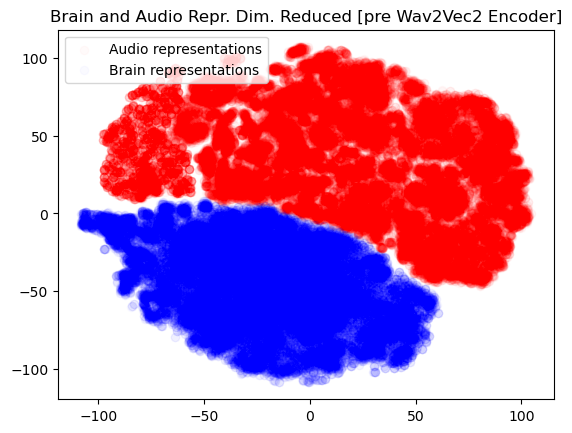

In [8]:
scatter_a_vs_b_dimreduced_nonagg(all_data_pre_w2venc_dimreduced, "Brain and Audio Repr. Dim. Reduced [pre Wav2Vec2 Encoder]")

### Visualize transcription idx clusters

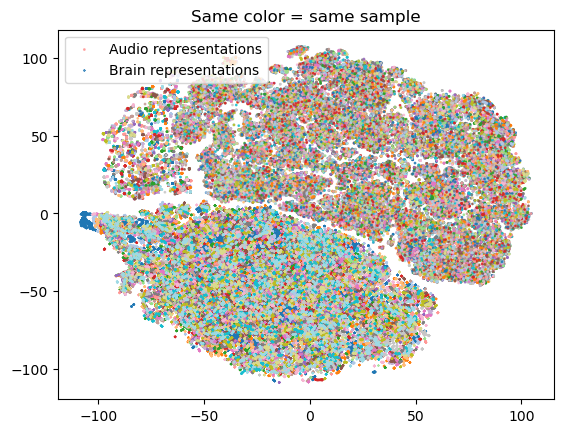

In [9]:
scatter_transcription_idx_clusters(all_data_pre_w2venc_dimreduced)


### Visualize audio / brain encoder clusters (with seq aggregation)

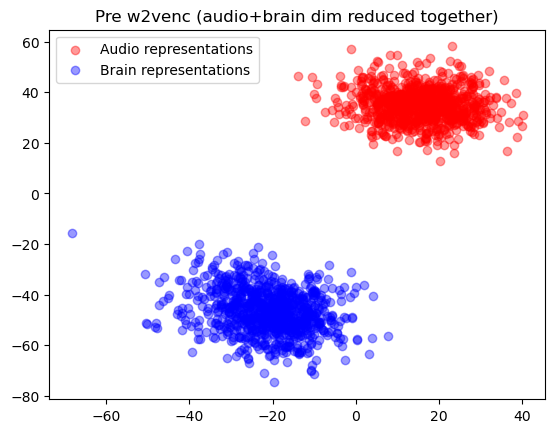

In [10]:
seq_dimreduced_pre_w2venc_avg_np = per_seq_avg_of_dimreduced_repr(all_data_pre_w2venc_dimreduced, all_data)
scatter_a_vs_b_dimreduced_aggregated(seq_dimreduced_pre_w2venc_avg_np, "Pre w2venc (audio+brain dim reduced together)")

### Visualize sample pairs (brain, audio)

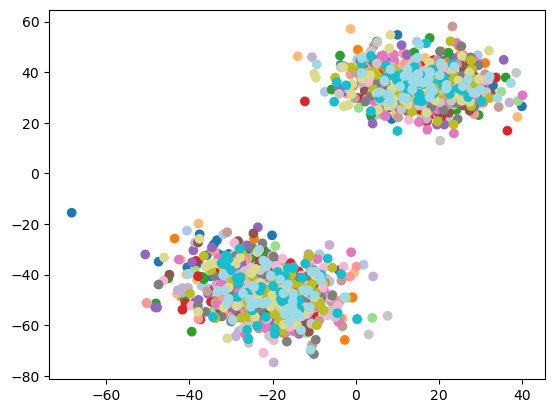

In [11]:
# Show scatter plot with each index modulo len(test_set) in one color

plt.scatter(seq_dimreduced_pre_w2venc_avg_np[:, 0], seq_dimreduced_pre_w2venc_avg_np[:, 1], c=[i % len(test_ds) for i in range(len(seq_dimreduced_pre_w2venc_avg_np))], cmap="tab20") #type: ignore

## Distance between dimensionality reduced audio and brain representation pairs

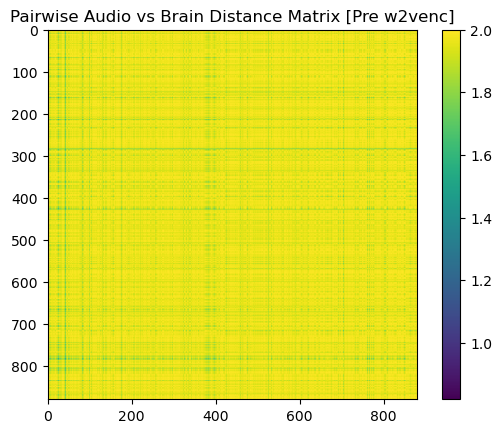

In [12]:
# Show distance matrix between dimensionality reduced audio and brain representation pairs
distmat_a_b_pairwise(seq_dimreduced_pre_w2venc_avg_np, "Pairwise Audio vs Brain Distance Matrix [Pre w2venc]")

## Transcription phoneme distance matrix

2% of distances calculated 

100% of distances calculated 

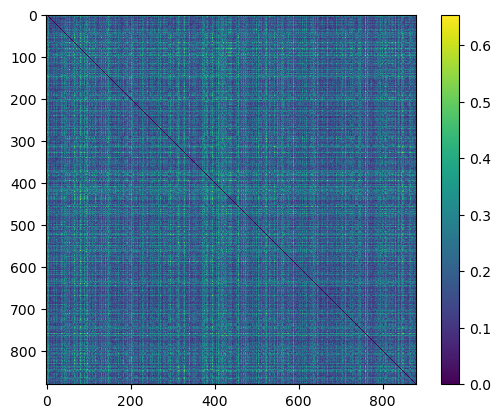

In [13]:
from scipy import spatial
from src.util.phoneme_helper import PHONE_DEF_SIL

test_phonemes = [test_ds[i].phonemes for i in range(len(test_ds))]

def get_phoneme_count_vec(phonemes: list[str]):
    phoneme_count = np.zeros(len(PHONE_DEF_SIL))
    for phoneme in phonemes:
        index = PHONE_DEF_SIL.index(phoneme)
        assert index != -1, f"Phoneme {phoneme} not found in phoneme list"
        phoneme_count[index] += 1
    return phoneme_count

label_distances = np.zeros((len(test_phonemes), len(test_phonemes)))
for i in range(len(test_phonemes)):
    p_count = get_phoneme_count_vec(test_phonemes[i])
    for j in range(len(test_phonemes)):
        label_distances[i][j] = spatial.distance.cosine(p_count, get_phoneme_count_vec(test_phonemes[j]))
    print(f"\r{int(((i+1)/len(test_transcriptions))*100)}% of distances calculated ", end="")
plt.imshow(label_distances, interpolation="nearest")
plt.colorbar()

In [14]:

def scatter_pairwise_label_distance_vs_dimreduced_distance(
    data: list[DimreducedSeries], title: str = "", repr_dist_function: str= "euclidean"
):
    labels_flattend_nodiag = flatten_square_matrix_rm_diag(label_distances)
    for series in data:
        repr_distances_flattened_nodiag = flatten_square_matrix_rm_diag(
            cdist(series.dimreduced_agg, series.dimreduced_agg, metric=repr_dist_function) # type: ignore
        )
        plt.scatter(
            labels_flattend_nodiag,
            repr_distances_flattened_nodiag,
            alpha=0.01,
            c=series.color,
            label=series.label,
            s=max(1,round(500 / sqrt(len(labels_flattend_nodiag)))),
        )
        z = np.polyfit(labels_flattend_nodiag, repr_distances_flattened_nodiag, 1)
        p = np.poly1d(z)
        plt.plot(
            labels_flattend_nodiag, p(labels_flattend_nodiag), f"r--", c=series.color
        )

    plt.xlabel("Phoneme distance (bag of phonemes cosine distance)")
    plt.ylabel("Dim reduced representation distance (euclidean)")
    plt.legend()
    plt.title(title)

    plt.show()

### Relationship between transcription phoneme distance and dim reduced representation pairs distance

/tmp/ipykernel_2486964/1936497506.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(


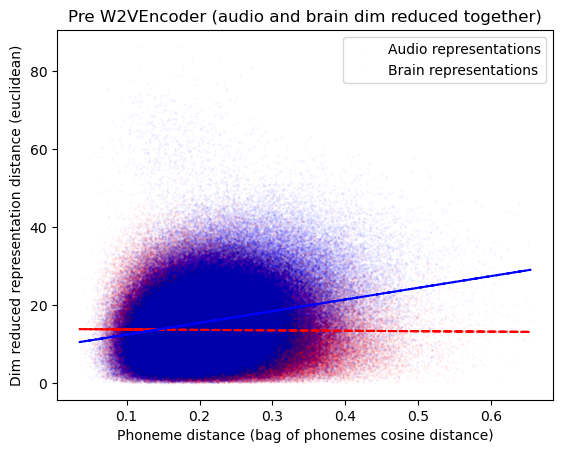

In [15]:
scatter_pairwise_label_distance_vs_dimreduced_distance(
    [
        DimreducedSeries(
            seq_dimreduced_pre_w2venc_avg_np[: len(test_ds)],
            "red",
            "Audio representations",
        ),
        DimreducedSeries(
            seq_dimreduced_pre_w2venc_avg_np[len(test_ds) :],
            "blue",
            "Brain representations",
        ),
    ],"Pre W2VEncoder (audio and brain dim reduced together)",
)

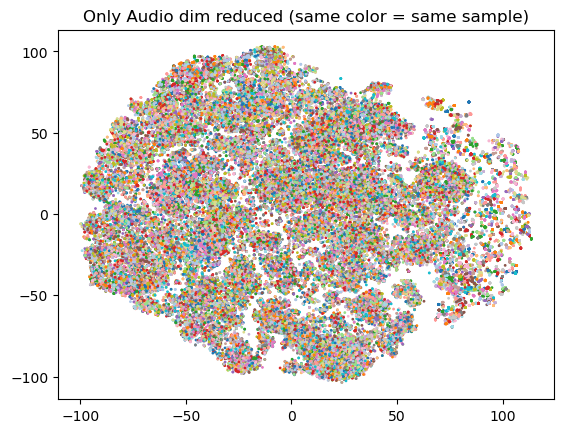

In [16]:
audio_only_dimreducer = TSNE(n_components=2)#PCA(n_components=2)
audio_data_dimreduced = audio_only_dimreducer.fit_transform(np.array([rep.numpy() for _, rep,_ in audio_representations.non_aggregated]))
plt.scatter(audio_data_dimreduced[:, 0], audio_data_dimreduced[:, 1], c=[rep.idx for rep in audio_representations.non_aggregated], cmap="tab20", label="Audio representations", s=1) # type: ignore
plt.title("Only Audio dim reduced (same color = same sample)")
plt.show()

### Audio only per seq averaged pairwise phoneme similarity <> distance relation

/tmp/ipykernel_2486964/1936497506.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(


/hpi/fs00/home/tobias.fiedler/miniconda3/envs/b2t/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


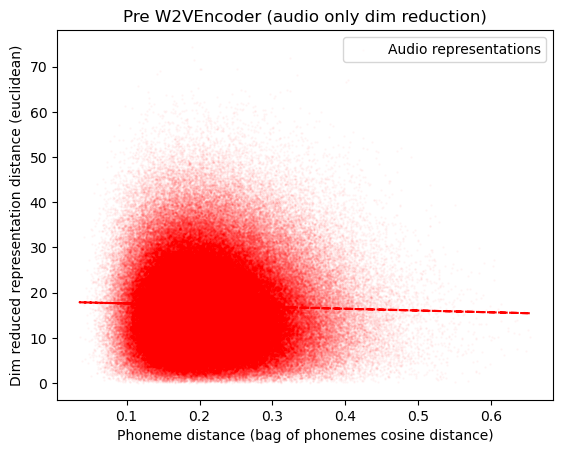

In [17]:
audio_seq_dimreduced_avg_np = per_seq_avg_of_dimreduced_repr(audio_data_dimreduced, audio_representations.non_aggregated)

scatter_pairwise_label_distance_vs_dimreduced_distance([DimreducedSeries(audio_seq_dimreduced_avg_np, "red", "Audio representations")], "Pre W2VEncoder (audio only dim reduction)")

### Brain only non aggregated pairwise phoneme similarity <> distance relation

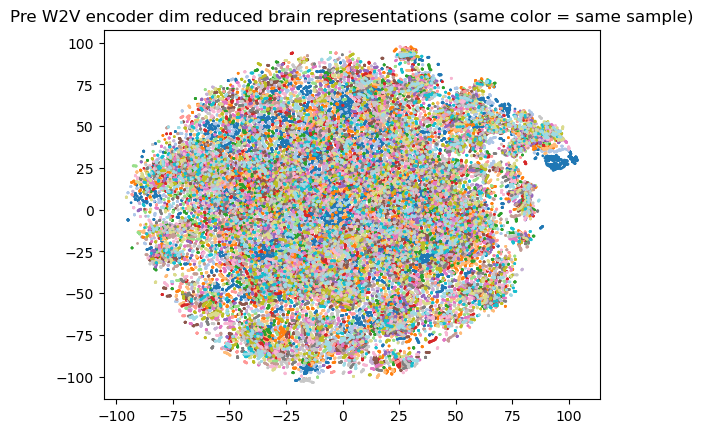

In [18]:
pre_w2venc_brain_only_dimreducer = TSNE(n_components=2)#PCA(n_components=2)
pre_w2venc_brain_data_dimreduced = pre_w2venc_brain_only_dimreducer.fit_transform(np.array([rep.numpy() for _, rep,_  in brain_representations.non_aggregated]))
plt.scatter(pre_w2venc_brain_data_dimreduced[:, 0], pre_w2venc_brain_data_dimreduced[:, 1], c=[rep.idx for rep in brain_representations.non_aggregated], cmap="tab20", label="Brain representations", s=1) # type: ignore
plt.title("Pre W2V encoder dim reduced brain representations (same color = same sample)")
plt.show()

/tmp/ipykernel_2486964/1936497506.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(


/hpi/fs00/home/tobias.fiedler/miniconda3/envs/b2t/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


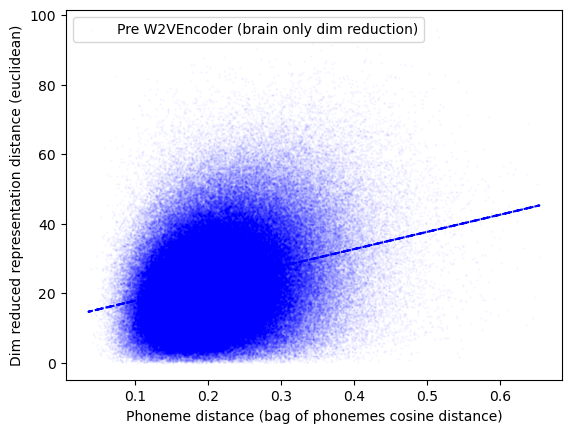

In [19]:
brain_seq_dimreduced_avg_np = per_seq_avg_of_dimreduced_repr(pre_w2venc_brain_data_dimreduced, brain_representations.non_aggregated)
scatter_pairwise_label_distance_vs_dimreduced_distance([DimreducedSeries(brain_seq_dimreduced_avg_np, "blue", "Pre W2VEncoder (brain only dim reduction)")])

## Post W2V2 encoder

In [20]:
all_data_post_w2venc_np = torch.stack([rep for _, _,rep in all_data]).numpy()
post_w2venc_dim_reducer = TSNE(n_components=2)
all_data_post_w2venc_dimreduced = post_w2venc_dim_reducer.fit_transform(all_data_post_w2venc_np)

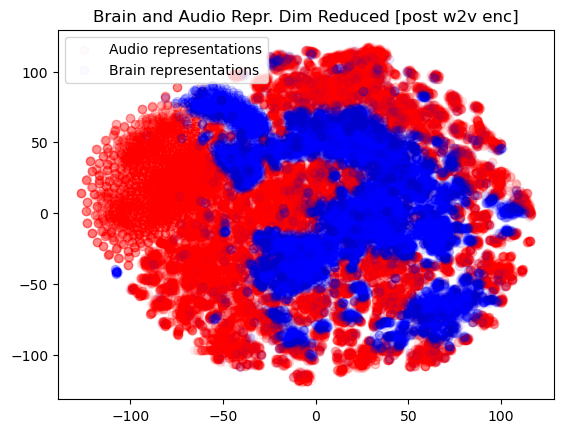

In [21]:
scatter_a_vs_b_dimreduced_nonagg(all_data_post_w2venc_dimreduced, "Brain and Audio Repr. Dim Reduced [post w2v enc]")

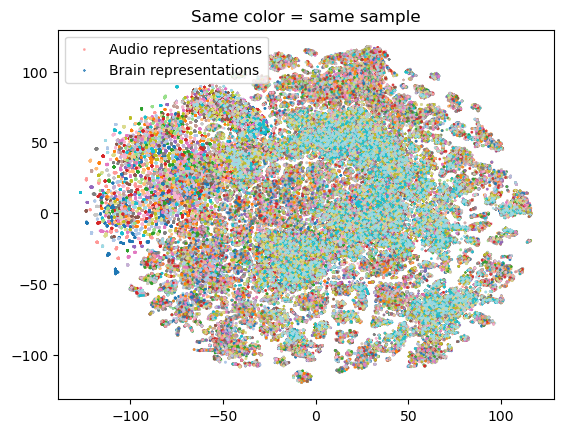

In [22]:
scatter_transcription_idx_clusters(all_data_post_w2venc_dimreduced)

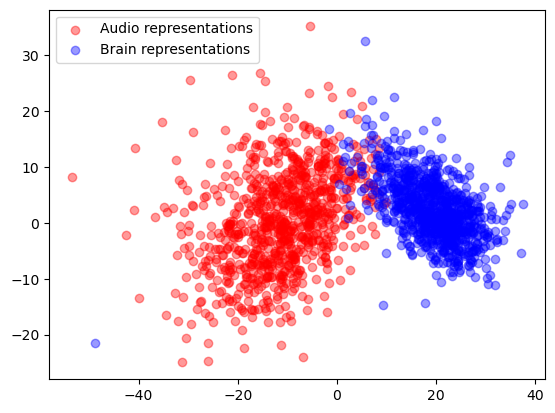

In [23]:
seq_dimreduced_post_w2venc_avg_np = per_seq_avg_of_dimreduced_repr(all_data_post_w2venc_dimreduced, all_data)
scatter_a_vs_b_dimreduced_aggregated(seq_dimreduced_post_w2venc_avg_np)

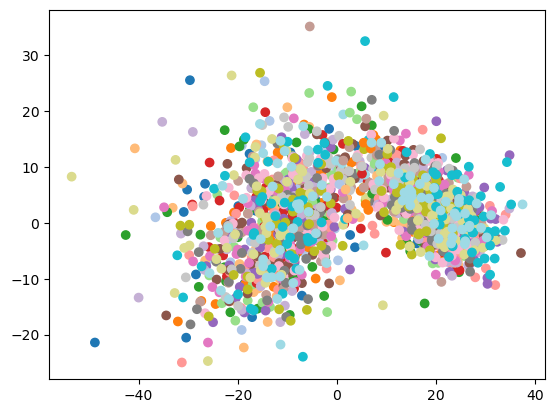

In [24]:

plt.scatter(seq_dimreduced_post_w2venc_avg_np[:, 0], seq_dimreduced_post_w2venc_avg_np[:, 1], c=[i % len(test_ds) for i in range(len(seq_dimreduced_post_w2venc_avg_np))], cmap="tab20") #type: ignore

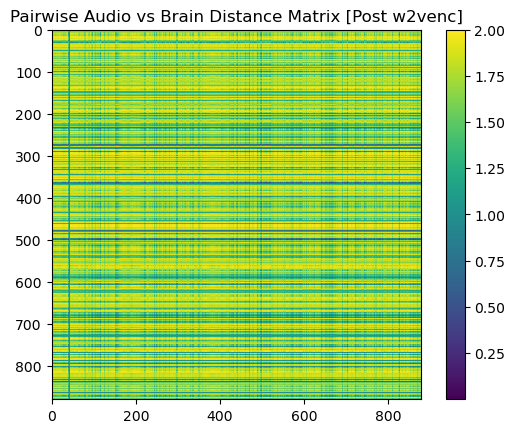

In [25]:
distmat_a_b_pairwise(seq_dimreduced_post_w2venc_avg_np, "Pairwise Audio vs Brain Distance Matrix [Post w2venc]")

/tmp/ipykernel_2486964/1936497506.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(


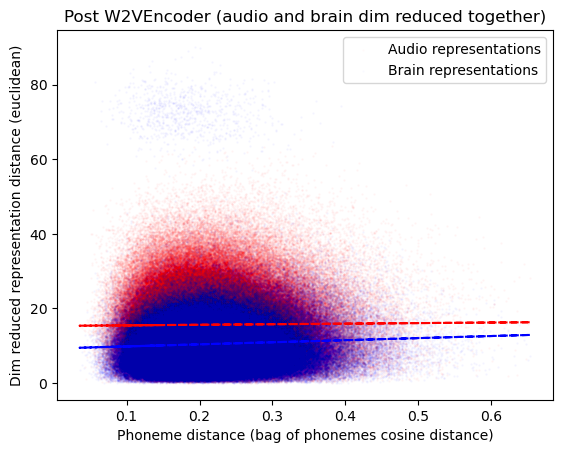

In [26]:
scatter_pairwise_label_distance_vs_dimreduced_distance(
    [
        DimreducedSeries(
            seq_dimreduced_post_w2venc_avg_np[: len(test_ds)],
            "red",
            "Audio representations",
        ),
        DimreducedSeries(
            seq_dimreduced_post_w2venc_avg_np[len(test_ds) :],
            "blue",
            "Brain representations",
        ),
    ],
    "Post W2VEncoder (audio and brain dim reduced together)",
)

#### Brain only

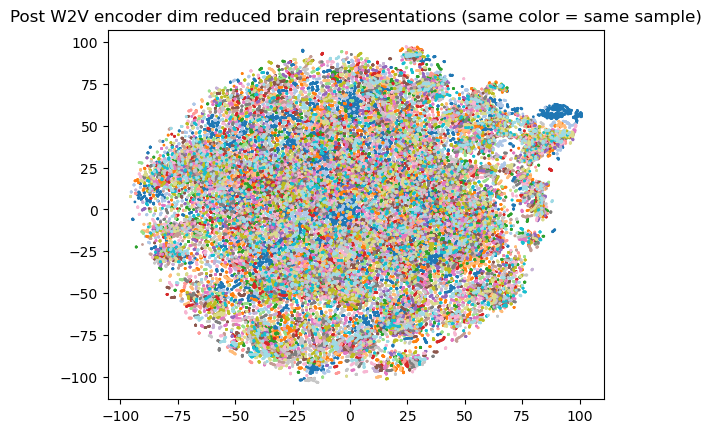

In [27]:
post_w2venc_brain_only_dimreducer = TSNE(n_components=2)#PCA(n_components=2)
post_w2venc_brain_data_dimreduced = post_w2venc_brain_only_dimreducer.fit_transform(np.array([rep.numpy() for _, rep,_  in brain_representations.non_aggregated]))
plt.scatter(post_w2venc_brain_data_dimreduced[:, 0], post_w2venc_brain_data_dimreduced[:, 1], c=[rep.idx for rep in brain_representations.non_aggregated], cmap="tab20", label="Brain representations", s=1) # type: ignore
plt.title("Post W2V encoder dim reduced brain representations (same color = same sample)")
plt.show()

/tmp/ipykernel_2486964/1936497506.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(


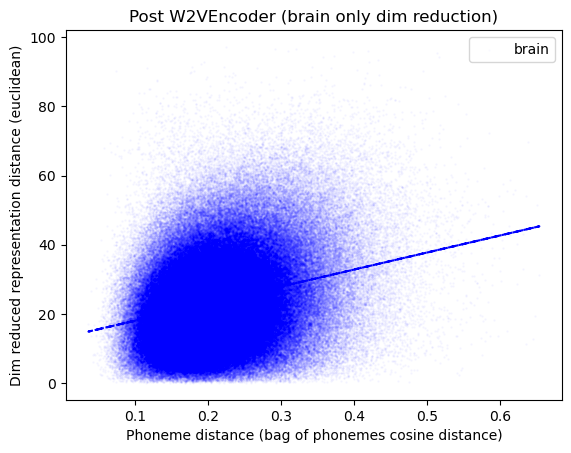

In [28]:
post_w2venc_brainonly_seq_dimreduced_avg_np = per_seq_avg_of_dimreduced_repr(post_w2venc_brain_data_dimreduced, brain_representations.non_aggregated)
scatter_pairwise_label_distance_vs_dimreduced_distance([DimreducedSeries(post_w2venc_brainonly_seq_dimreduced_avg_np, "blue", "brain")], "Post W2VEncoder (brain only dim reduction)")

#### Audio only

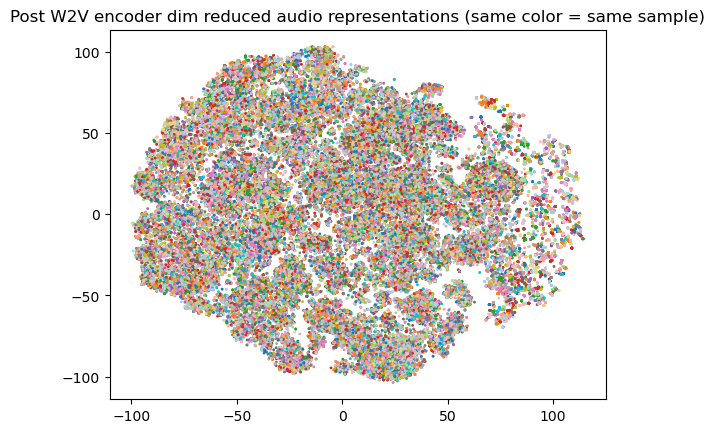

In [29]:
post_w2venc_audio_only_dimreducer = TSNE(n_components=2)#PCA(n_components=2)
post_w2venc_audio_data_dimreduced = post_w2venc_audio_only_dimreducer.fit_transform(np.array([rep.numpy() for _, rep,_  in audio_representations.non_aggregated]))
plt.scatter(post_w2venc_audio_data_dimreduced[:, 0], post_w2venc_audio_data_dimreduced[:, 1], c=[rep.idx for rep in audio_representations.non_aggregated], cmap="tab20", label="Brain representations", s=1) # type: ignore
plt.title("Post W2V encoder dim reduced audio representations (same color = same sample)")
plt.show()

/tmp/ipykernel_2486964/1936497506.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(


/hpi/fs00/home/tobias.fiedler/miniconda3/envs/b2t/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


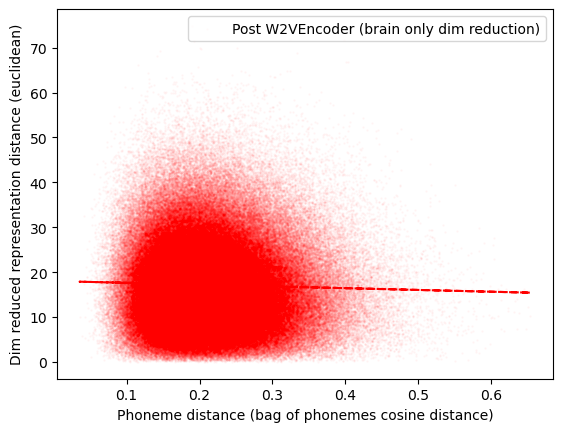

In [30]:
post_w2venc_audioonly_seq_dimreduced_avg_np = per_seq_avg_of_dimreduced_repr(post_w2venc_audio_data_dimreduced, audio_representations.non_aggregated)
scatter_pairwise_label_distance_vs_dimreduced_distance([DimreducedSeries(post_w2venc_audioonly_seq_dimreduced_avg_np, "red", "Post W2VEncoder (brain only dim reduction)")])

In [31]:
brain_representations.aggregated[0].post_w2vencoder.shape

torch.Size([768])

/tmp/ipykernel_2486964/1936497506.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(


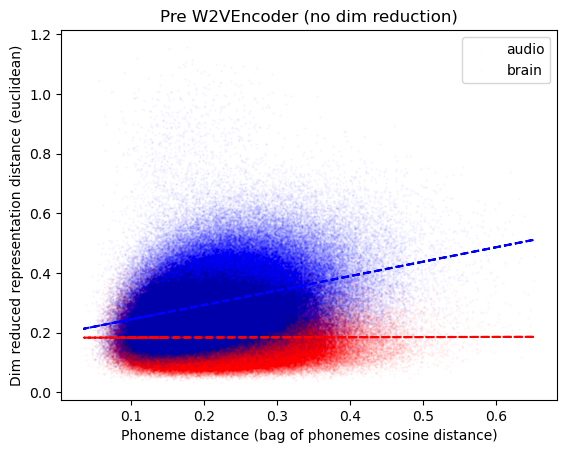

In [32]:
data = np.stack([repr.numpy() for _,repr,_ in (audio_representations.aggregated + brain_representations.aggregated)])
scatter_pairwise_label_distance_vs_dimreduced_distance([DimreducedSeries(data[:len(test_ds)], "red", "audio"), DimreducedSeries(data[len(test_ds):], "blue", "brain")], "Pre W2VEncoder (no dim reduction)", "cosine")

/tmp/ipykernel_2486964/1936497506.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(


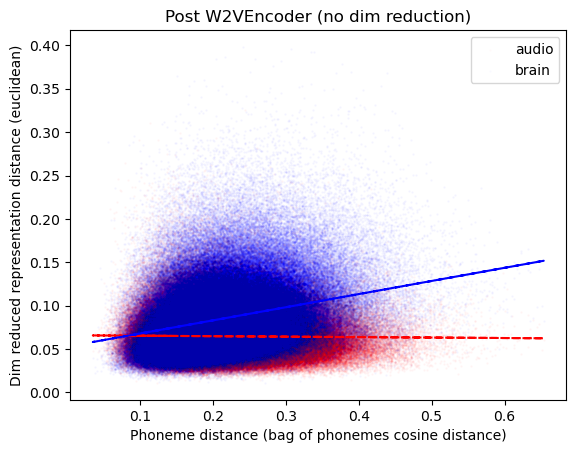

In [33]:
data = np.stack([repr.numpy() for _,_,repr in (audio_representations.aggregated + brain_representations.aggregated)])
scatter_pairwise_label_distance_vs_dimreduced_distance([DimreducedSeries(data[:len(test_ds)], "red", "audio"), DimreducedSeries(data[len(test_ds):], "blue", "brain")], "Post W2VEncoder (no dim reduction)", "cosine")